In [3]:
import os
import sys
this = os.getcwd()
path = this[:this.rfind("/")]
if not path in sys.path: sys.path.append(path)

import pandas as pd
import matplotlib
from datos import FEATURES_DISPONIBLES
from modelo import Modelo

pd.set_option('display.max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [4]:
import xgboost as xgb

In [5]:
class XGBoost(Modelo):
    """
    """
    
    def cargar_datos(self):
        """
        """
        excluir = {
            "tipodepropiedad", "ciudad", "provincia", "idzona", "fecha"
        }
        features = FEATURES_DISPONIBLES - excluir
        super().cargar_datos(features)
        self.train_data = self.train_data.drop(columns=["fecha"])
        self.test_data = self.test_data.drop(columns=["fecha"])
        self.submit_data = self.submit_data.drop(columns=["fecha"])
        
    def entrenar(self):
        """
        """
        pass
        

In [24]:
modelo = XGBoost()
modelo.cargar_datos()

instanciar demoro 0.0 segundos
cargar demoro 1.3 segundos


In [13]:
def split_data_label(df, label):
    data = df.loc[:, df.columns != label]
    label = df[label].values
    return data, label

In [25]:
label = 'gimnasio'
train_data, train_label = split_data_label(modelo.train_data, label)
test_data, test_label = split_data_label(modelo.test_data, label)

dtrain = xgb.DMatrix(train_data, label=train_label)
dtest = xgb.DMatrix(test_data, label=test_label)

In [26]:
params = {'max_depth': 2, 'eta': 1, 'objective': 'binary:logistic', 'nthread': 4, 'eval_metric': 'auc'}
booster = xgb.train(params, dtrain)

In [27]:
predictions = booster.predict(dtest)

In [41]:
result = pd.DataFrame([modelo.test_data[label].values, predictions]).T
result.columns = ["real", "pred"]
result["label"] = result["pred"].map(lambda x: x > 0.5)
result["ok"] = (result["real"] == result["label"])

In [42]:
result["ok"].value_counts()

True     57212
False     2788
Name: ok, dtype: int64

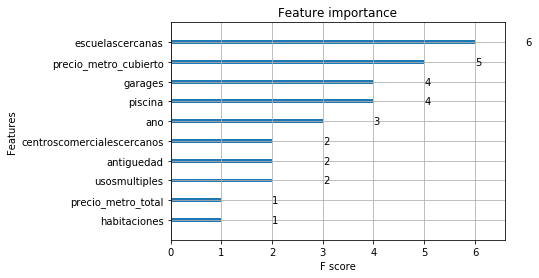

In [44]:
plot = xgb.plot_importance(booster)